# Inducing grokking (delayed generalization) on MNIST

This notebook reproduces results akin to Figure 3(d) from the paper [Omnigrok: Grokking Beyond Algorithmic Data](https://arxiv.org/abs/2210.01117), showing how increasing initialization scale leads to grokking (delayed generalization) on MNIST.

### Imports and setup

In [9]:
!nvidia-smi

Sun Dec  1 02:31:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 82%   51C    P0             40W /  170W |    2703MiB /   6144MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
from collections import defaultdict
from itertools import islice
import random
import time
from pathlib import Path
import math

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

In [11]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    """Computes accuracy of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, dataset, loss_function, device, N=2000, batch_size=50):
    """Computes mean loss of `network` on `dataset`.
    """
    with torch.no_grad():
        N = min(len(dataset), N)
        batch_size = min(batch_size, N)
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss_fn = loss_function_dict[loss_function](reduction='sum')
        one_hots = torch.eye(10, 10).to(device)
        total = 0
        points = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            y = network(x.to(device))
            if loss_function == 'CrossEntropy':
                total += loss_fn(y, labels.to(device)).item()
            elif loss_function == 'MSE':
                total += loss_fn(y, one_hots[labels]).item()
            points += len(labels)
        return total / points

In [12]:
optimizer_dict = {
    'AdamW': torch.optim.AdamW,
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD
}

activation_dict = {
    'ReLU': nn.ReLU,
    'Tanh': nn.Tanh,
    'Sigmoid': nn.Sigmoid,
    'GELU': nn.GELU
}

loss_function_dict = {
    'MSE': nn.MSELoss,
    'CrossEntropy': nn.CrossEntropyLoss
}

### Choose experiment parameters

In [13]:
train_points = 1000
optimization_steps = 100000
batch_size = 200
loss_function = 'MSE'   # 'MSE' or 'CrossEntropy'
optimizer = 'AdamW'     # 'AdamW' or 'Adam' or 'SGD'
weight_decay = 0.01
lr = 1e-3
initialization_scale = 8.0
download_directory = "."

depth = 3               # the number of nn.Linear modules in the model
width = 200
activation = 'ReLU'     # 'ReLU' or 'Tanh' or 'Sigmoid' or 'GELU'

log_freq = math.ceil(optimization_steps / 150)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
dtype = torch.float64
seed = 0

cuda:0


### Train

In [14]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

# load dataset
train = torchvision.datasets.MNIST(root=download_directory, train=True, 
    transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root=download_directory, train=False, 
    transform=torchvision.transforms.ToTensor(), download=True)
train = torch.utils.data.Subset(train, range(train_points))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

assert activation in activation_dict, f"Unsupported activation function: {activation}"
activation_fn = activation_dict[activation]

# create model
layers = [nn.Flatten()]
for i in range(depth):
    if i == 0:
        layers.append(nn.Linear(784, width))
        layers.append(activation_fn())
    elif i == depth - 1:
        layers.append(nn.Linear(width, 10))
    else:
        layers.append(nn.Linear(width, width))
        layers.append(activation_fn())
mlp = nn.Sequential(*layers).to(device)
with torch.no_grad():
    for p in mlp.parameters():
        p.data = initialization_scale * p.data

# create optimizer
assert optimizer in optimizer_dict, f"Unsupported optimizer choice: {optimizer}"
optimizer = optimizer_dict[optimizer](mlp.parameters(), lr=lr, weight_decay=weight_decay)

# define loss function
assert loss_function in loss_function_dict
loss_fn = loss_function_dict[loss_function]()


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
last_layer_norms = []
log_steps = []

steps = 0
one_hots = torch.eye(10, 10).to(device)
with tqdm(total=optimization_steps) as pbar:
    for x, labels in islice(cycle(train_loader), optimization_steps):
        if (steps < 30) or (steps < 150 and steps % 10 == 0) or steps % log_freq == 0:
            train_losses.append(compute_loss(mlp, train, loss_function, device, N=len(train)))
            train_accuracies.append(compute_accuracy(mlp, train, device, N=len(train)))
            test_losses.append(compute_loss(mlp, test, loss_function, device, N=len(test)))
            test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
            log_steps.append(steps)
            with torch.no_grad():
                total = sum(torch.pow(p, 2).sum() for p in mlp.parameters())
                norms.append(float(np.sqrt(total.item())))
                last_layer = sum(torch.pow(p, 2).sum() for p in mlp[-1].parameters())
                last_layer_norms.append(float(np.sqrt(last_layer.item())))
            pbar.set_description("L: {0:1.1e}|{1:1.1e}. A: {2:2.1f}%|{3:2.1f}%".format(
                train_losses[-1],
                test_losses[-1],
                train_accuracies[-1] * 100, 
                test_accuracies[-1] * 100))

        optimizer.zero_grad()
        y = mlp(x.to(device))
        if loss_function == 'CrossEntropy':
            loss = loss_fn(y, labels.to(device))
        elif loss_function == 'MSE':
            loss = loss_fn(y, one_hots[labels])
        loss.backward()
        optimizer.step()
        steps += 1
        pbar.update(1)



L: 3.2e-05|2.1e-01. A: 100.0%|89.1%: 100%|██████████| 100000/100000 [1:00:33<00:00, 27.52it/s]


Text(0.5, 1.0, 'depth-3 width-200 ReLU MLP on MNIST\nUnconstrained Optimization α = 8.0')

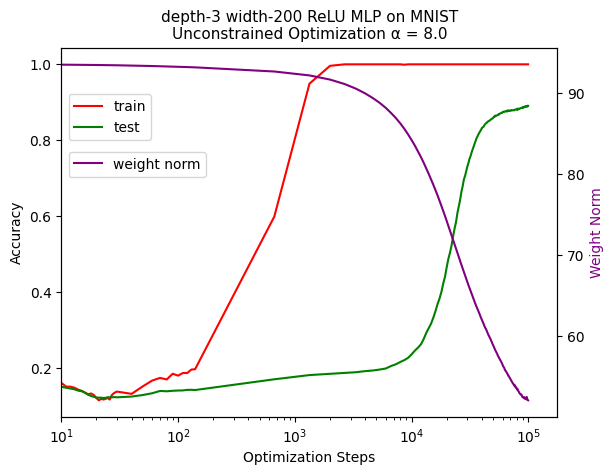

In [15]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.xscale('log')
plt.xlim(10, None)
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.legend(loc=(0.015, 0.75))

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
# ax2.set_ylim(27, 63)
plt.legend(loc=(0.015, 0.65))
plt.title(f"depth-3 width-200 ReLU MLP on MNIST\nUnconstrained Optimization α = {initialization_scale}", fontsize=11)
# plt.tight_layout()